In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#### Step 1. Camera Calibration 

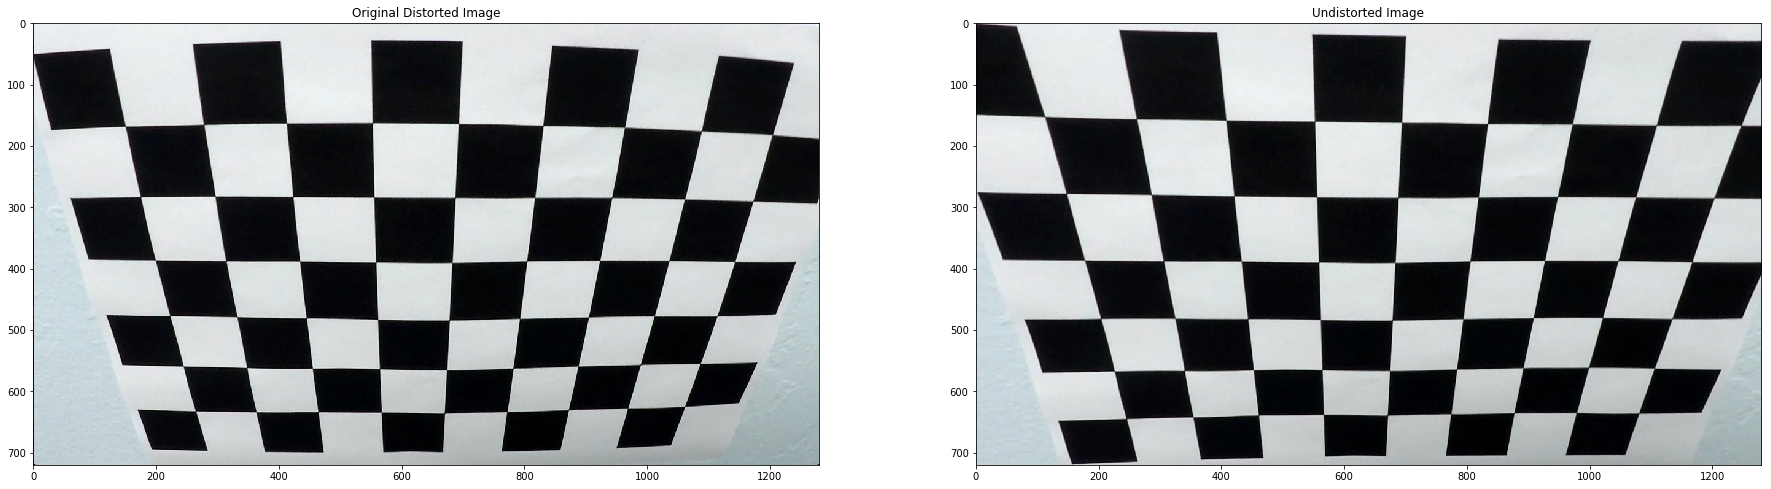

In [2]:
#Number of check boxes
nx = 9
ny = 6
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
chess_images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in chess_images:
    #print('Reading',fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        
# plot original and undistorted images
image_size = gray.shape[::-1]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
img = cv2.imread('camera_cal/calibration2.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax1.set_title('Original Distorted Image')
ax2.imshow(undist)
ax2.set_title('Undistorted Image')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

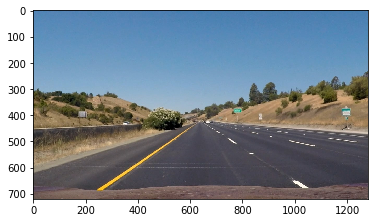

In [3]:
# Uploading original image
org_image = plt.imread('test_images/straight_lines1.jpg')
plt.imshow(org_image)

#### Step 2. Correcting distortion

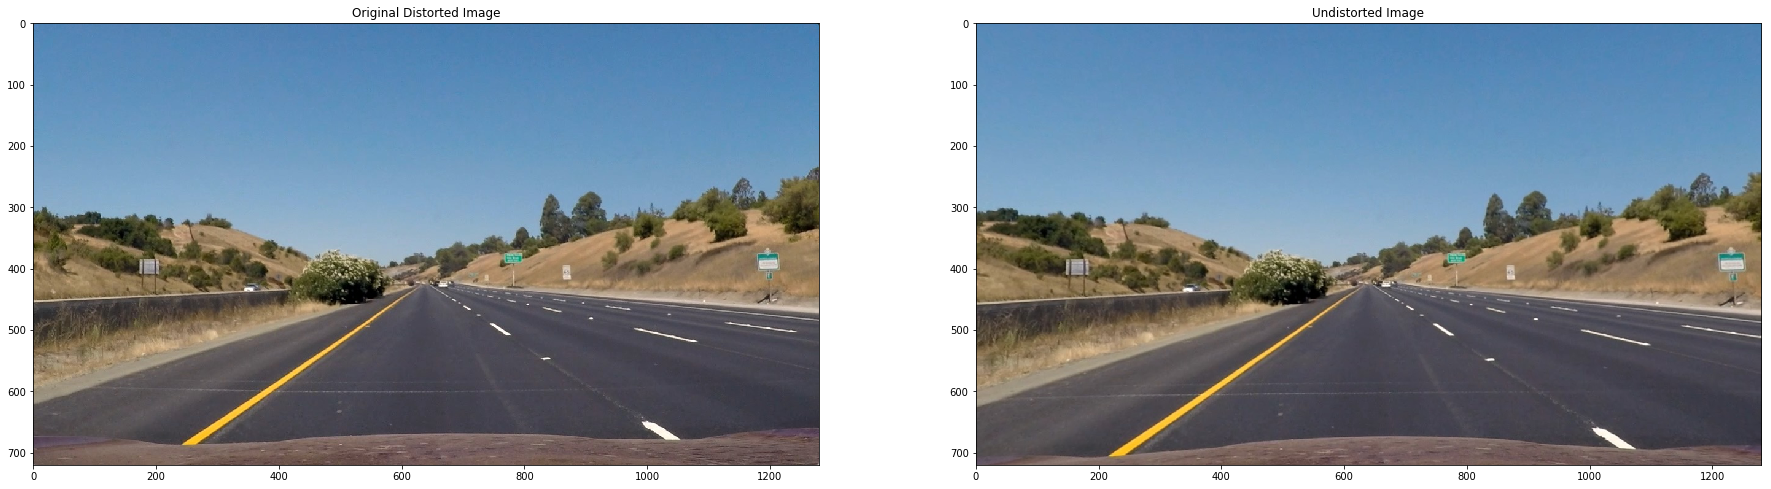

In [4]:
#Function for undistorting images.
def undistort_image(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

undist_image = undistort_image(org_image, mtx, dist)
# plot original and undistorted images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(org_image)
ax1.set_title('Original Distorted Image')
ax2.imshow(undist_image)
ax2.set_title('Undistorted Image')
mpimg.imsave("img2.jpg", undist_image)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

**Step 3. Thresholding**

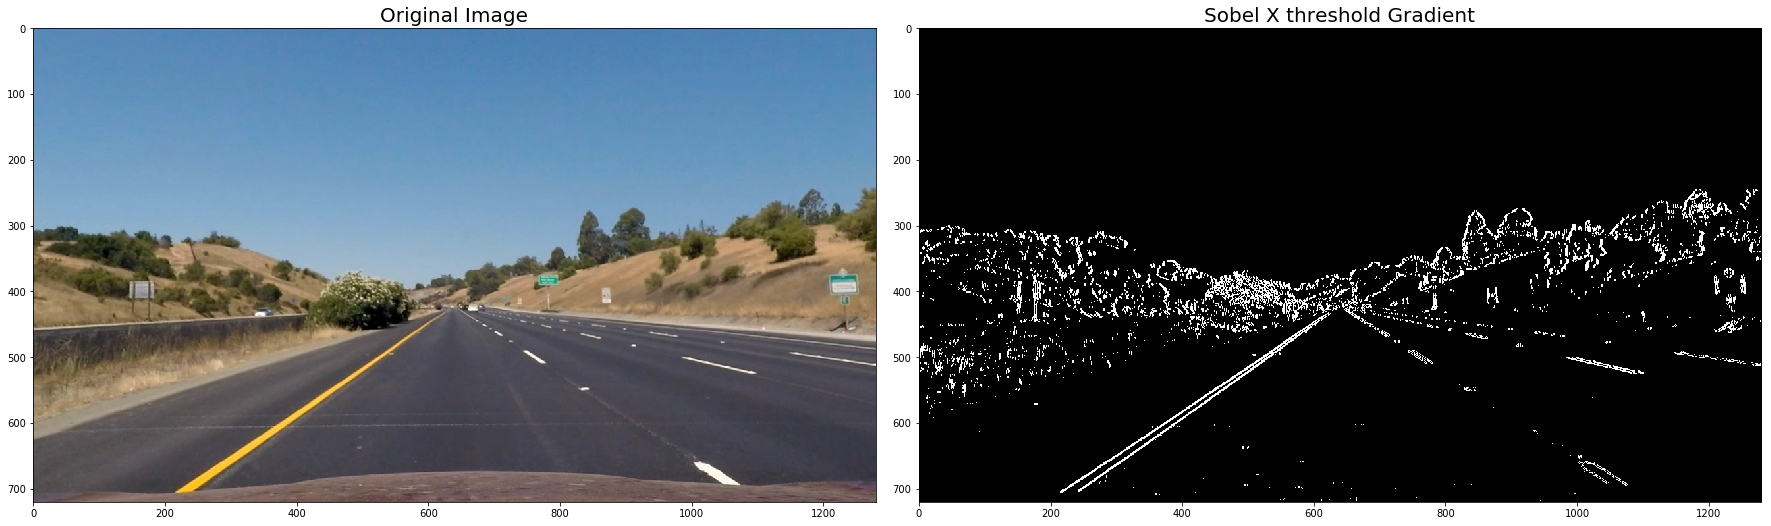

In [5]:
#Absoulte sobel thresholding
def abs_sobel_thresh(img, orient='x', sobel_thresh=(0,255)):
    
    #Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #Take the derivative in x or y given orient = 'x' or 'y'
    if(orient == 'x'):
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0)
    elif (orient == 'y'):
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1)
    #Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    #Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    #Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    s_binary = np.zeros_like(scaled_sobel)
    s_binary[(scaled_sobel > sobel_thresh[0]) & (scaled_sobel < sobel_thresh[1])] = 1
    #Return this mask as your binary_output image
    binary_output = np.copy(s_binary) # Remove this line
    return binary_output

sx_binary = abs_sobel_thresh(undist_image, orient='x', sobel_thresh = (20,100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(sx_binary, cmap='gray')
ax2.set_title('Sobel X threshold Gradient', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

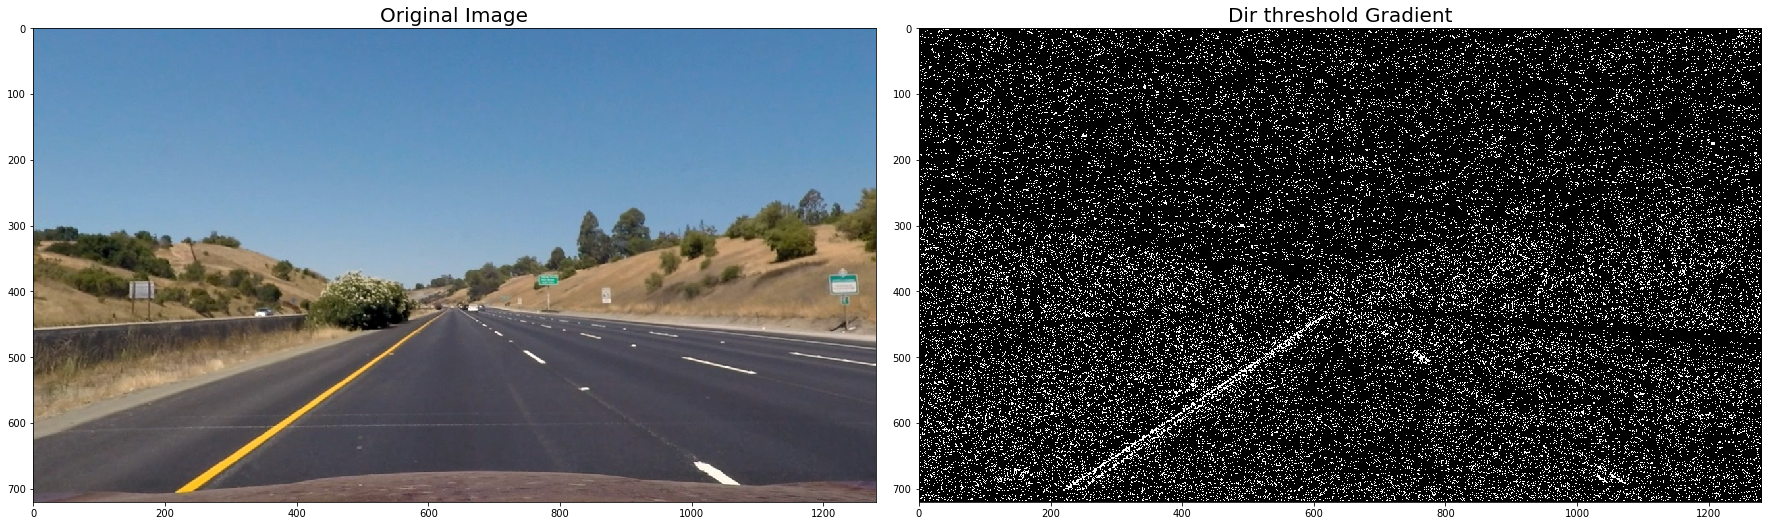

In [6]:
#Sobel direction thresholding
def dir_sobel_thresh(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    #Convert to gray scale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #Calculate the gradient in x and y direction
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    #Absolute sobel value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    #Calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    #Apply threshold
    mask = np.zeros_like(direction)
    mask[(direction >= dir_thresh[0]) & (direction <= dir_thresh[1])] = 1
    #Return mask as your binary_output image
    return mask

# Run the function
sobel_dir_binary = dir_sobel_thresh(undist_image, dir_thresh=(0.95, 1.15))
#Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(sobel_dir_binary, cmap='gray')
ax2.set_title('Dir threshold Gradient', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

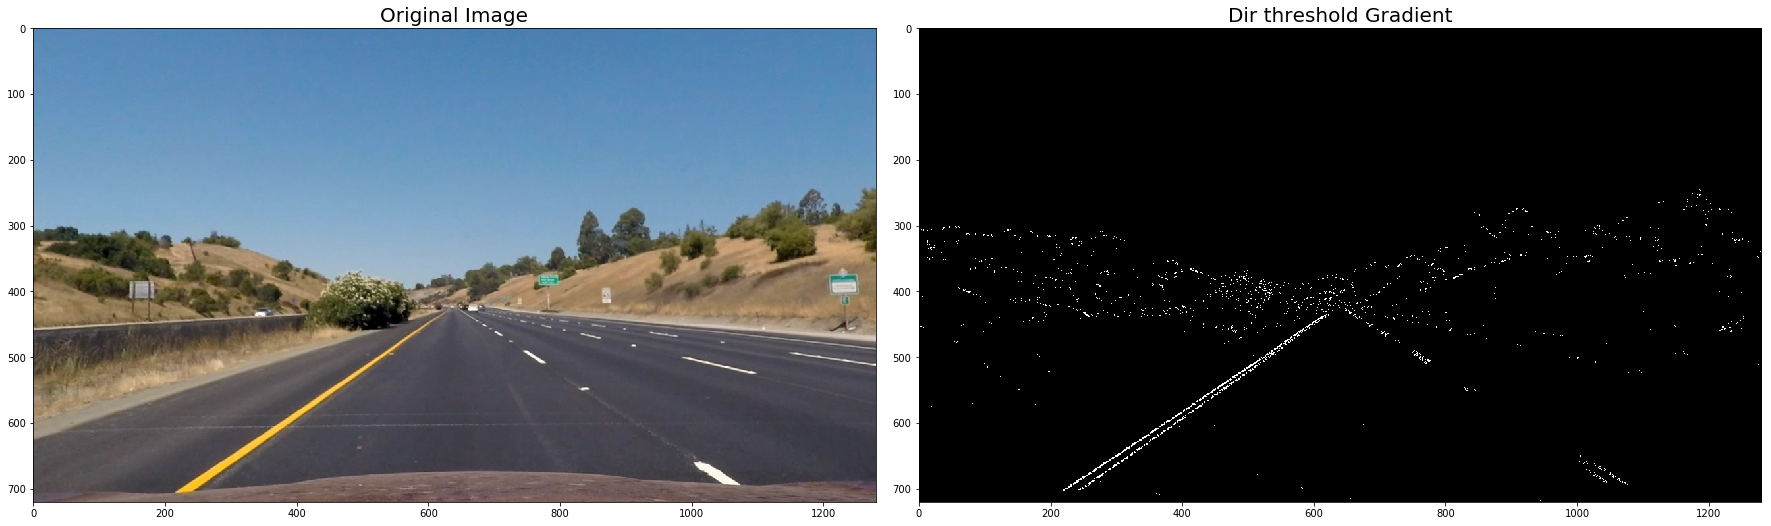

In [7]:
#Combining sobelx and sobel direction
def sobel_abs_dir(img,orient='x', sobel_thresh=(0,255),sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    sx_binary = abs_sobel_thresh(undist_image, orient='x', sobel_thresh = (20,100))
    sobel_dir_binary = dir_sobel_thresh(undist_image, dir_thresh=(0.95, 1.15))
    combine_sobel = np.zeros_like(sx_binary)
    combine_sobel[(sx_binary == 1) & (sobel_dir_binary == 1)] = 1
    return combine_sobel

combine_sobel_img = sobel_abs_dir(undist_image,orient='x', sobel_thresh=(20,100),sobel_kernel=3, dir_thresh=(0.7,1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(combine_sobel_img, cmap='gray')
ax2.set_title('Dir threshold Gradient', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

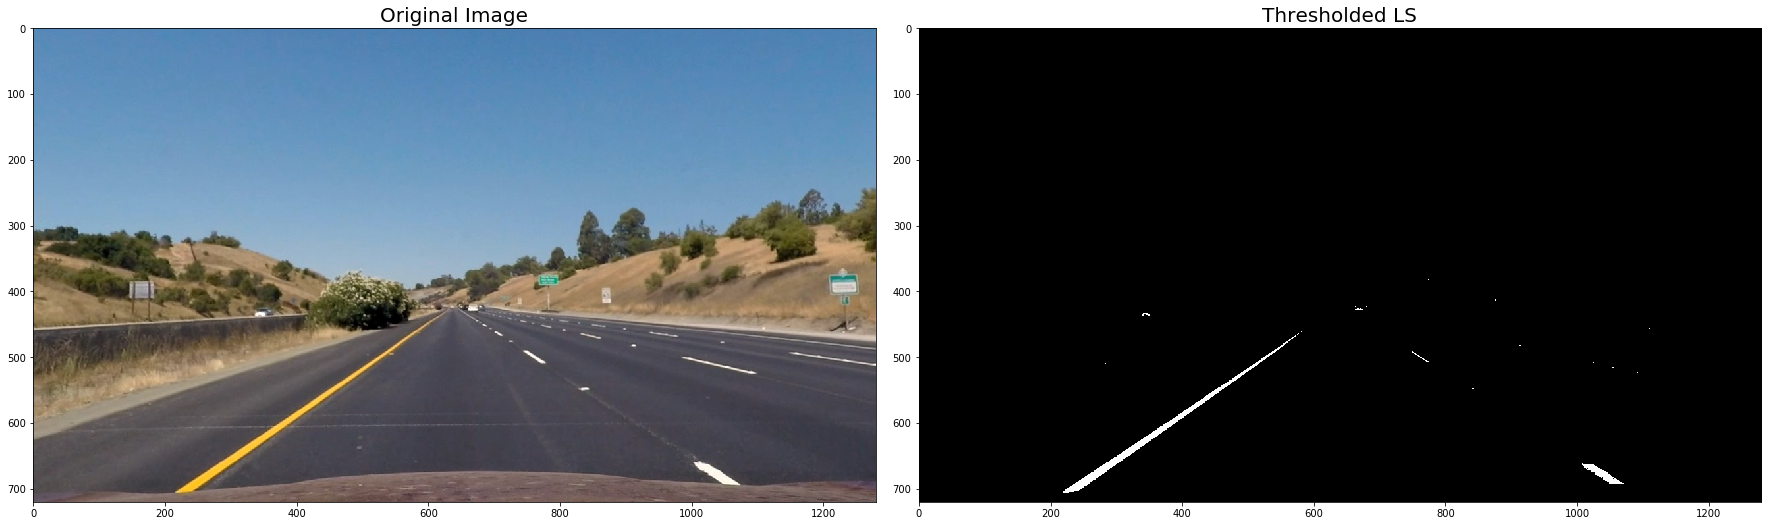

In [8]:
#Thresholding accross L and S channels of the converted HLS image
def hls_select(img,l_thresh=(0,255),s_thresh=(0, 255)):
    #Convert to HLS color space
    img_hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    l_channel = img_hls[:,:,1]
    s_channel = img_hls[:,:,2]
    #Apply a threshold to the S channel
    img_binary = np.zeros_like(l_channel)
    img_binary[((l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])) & ((s_channel > s_thresh[0]) & (s_channel <= s_thresh[1]))] = 1
    # Return a binary image of threshold result
    return img_binary
    
ls_binary = hls_select(undist_image, l_thresh=(120, 255), s_thresh=(150, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(ls_binary, cmap='gray')
ax2.set_title('Thresholded LS', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

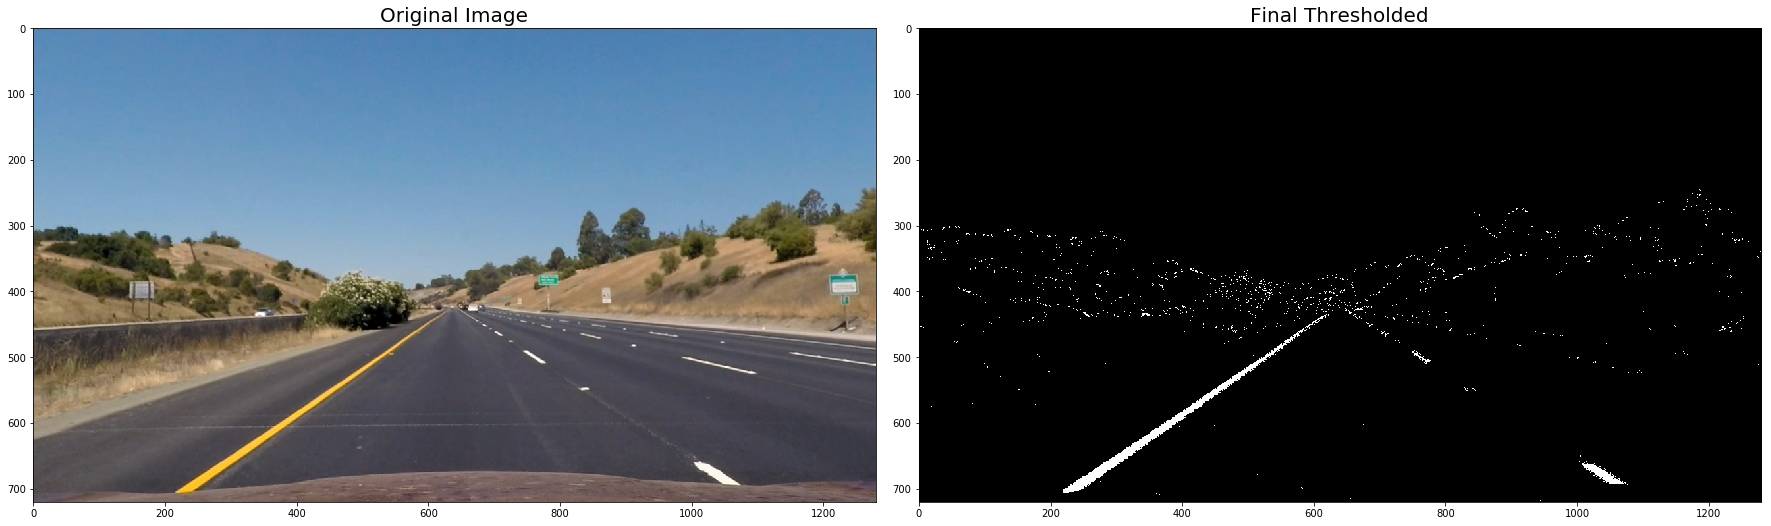

In [9]:
# Final thresholding step. Combine the two binary thresholds
def combined_thresholds(img, orient='x', sobel_thresh=(0,255),l_thresh=(0,255),s_thresh=(0, 255),sobel_kernel=3, dir_thresh=(0,np.pi/2)):
    
    sob_binary = sobel_abs_dir(undist_image,orient='x', sobel_thresh=sobel_thresh,sobel_kernel=sobel_kernel, dir_thresh=dir_thresh)
    ls_binary = hls_select(img, l_thresh=l_thresh, s_thresh=s_thresh)
    combined_binary = np.zeros_like(ls_binary)
    combined_binary[(ls_binary == 1) | (sob_binary == 1)] = 1
    
    return combined_binary

combined_binary = combined_thresholds(undist_image, orient='x', sobel_thresh=(20,100),l_thresh=(120,255),s_thresh=(150, 255),sobel_kernel=3, dir_thresh=(0.7,1.3))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Final Thresholded', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

**Step 4. Region masking**

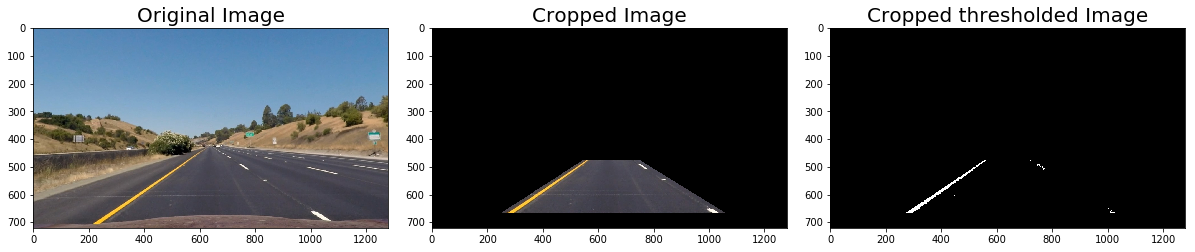

In [10]:
#Cropping out region where road can possibly be
def region_of_interest(img):

    m1,n1 = 543,476
    m2,n2 = 248,666
    m3,n3 = 1058,666
    m4,n4 = 750,476
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   

    #Region Mask creation
    vertices = np.array([[[m1,n1],[m2,n2],[m3,n3],[m4,n4]]],dtype=np.int32)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

masked_image_org = region_of_interest(org_image)
masked_image_thres = region_of_interest(combined_binary)

# Plot the result
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 6))
f.tight_layout()
ax1.imshow(undist_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(masked_image_org, cmap='gray')
ax2.set_title('Cropped Image', fontsize=20)
ax3.imshow(masked_image_thres, cmap='gray')
ax3.set_title('Cropped thresholded Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

**Step 5. Prespective Transform**

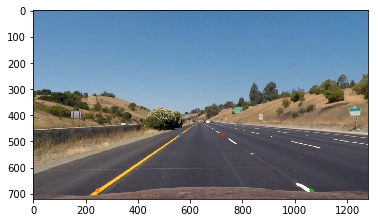

In [11]:
#Creating source points.
x1,y1 = 562,470
x2,y2 = 243,686
x3,y3 = 1063,686
x4,y4 = 721,470
source_points = np.float32([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])
plt.imshow(undist_image)
plt.plot(x1,y1,'.')
plt.plot(x2,y2,'.')
plt.plot(x3,y3,'.')
plt.plot(x4,y4,'.')


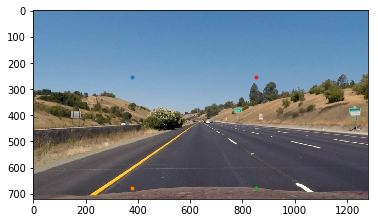

In [12]:
#Creating destination points
a1,b1 = 378,255
a2,b2 = 378,677
a3,b3 = 853,677
a4,b4 = 853,255
width,height = undist_image.shape[1::-1]
destination_points = np.float32([[a1,b1],[a2,b2],[a3,b3],[a4,b4]])
plt.imshow(undist_image)
plt.plot(a1,b1,'.')
plt.plot(a2,b2,'.')
plt.plot(a3,b3,'.')
plt.plot(a4,b4,'.')

In [13]:
#Calculating M value
M = cv2.getPerspectiveTransform(source_points,destination_points)
M_inv = cv2.getPerspectiveTransform(destination_points,source_points)

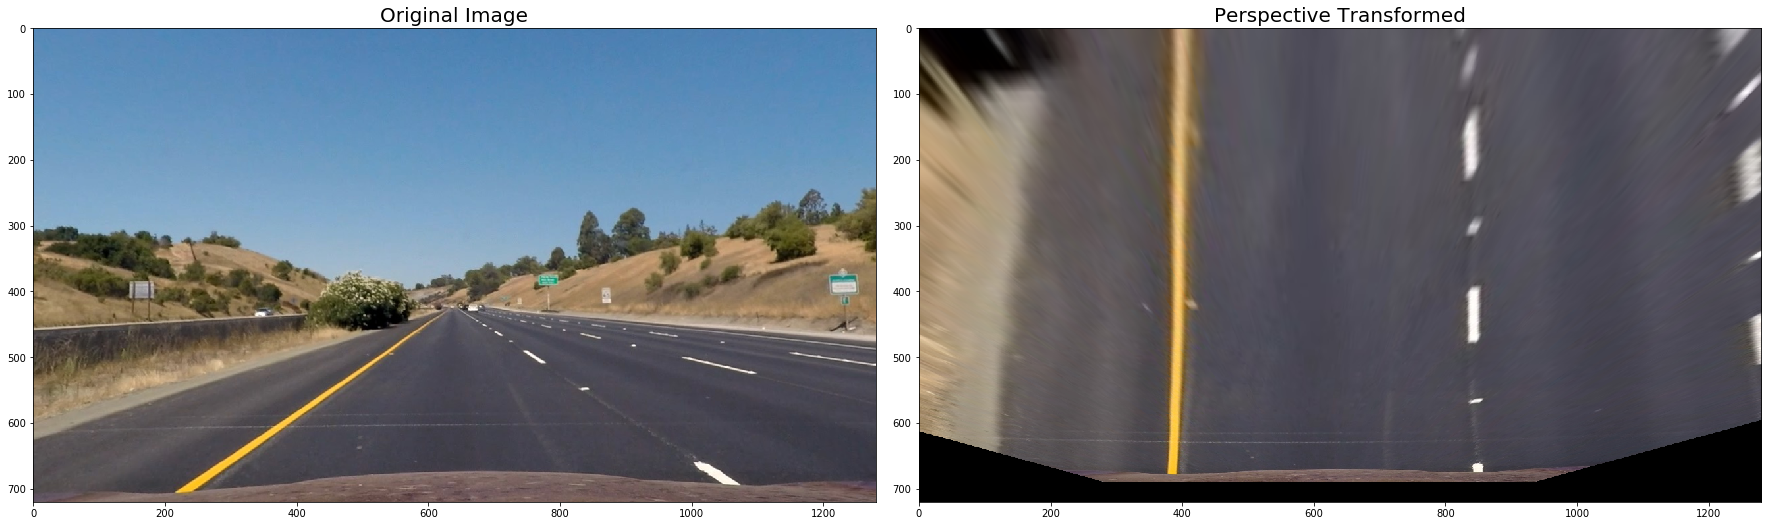

In [14]:
#Perspective transform function
def perspective_transform(image, M):
    img_size = (image.shape[1], image.shape[0])
    warped_image = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped_image

warped_image = perspective_transform(org_image,M)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warped_image)
ax2.set_title('Perspective Transformed', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



**Step 6. Final image processing function**

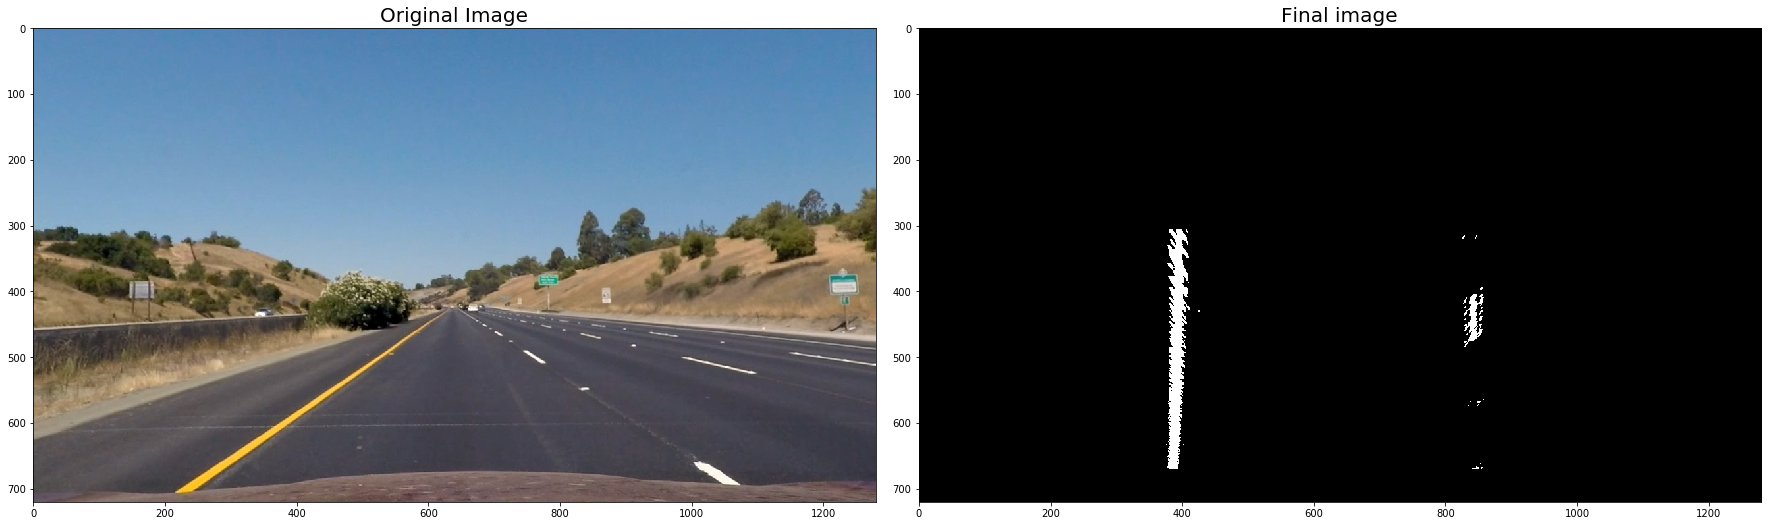

In [15]:
#It takes a color image and return a undistorted,thresholded,masked and bird's eye view image
def image_processing(img):
    # Image undistort
    op = undistort_image(img, mtx, dist)
    # thresholding
    op = combined_thresholds(op, orient='x', sobel_thresh=(50,100),l_thresh=(130,255),s_thresh=(130, 255),sobel_kernel=3, dir_thresh=(0.7,1.3))
    # region of interest
    op = region_of_interest(op)
    # Bird's eye view
    op = perspective_transform(op, M)
     
    return op

binary_warped = image_processing(org_image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(binary_warped,cmap='gray')
ax2.set_title('Final image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

**Plotting histogram**

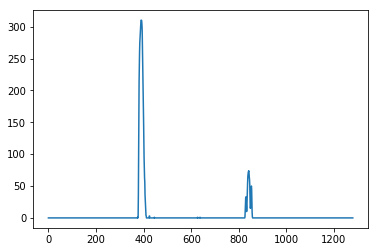

In [16]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

**Step 7. Sliding window funtion**

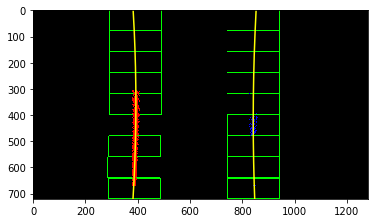

In [17]:
def sliding_window(binary_warped_sw,left_fit_array,right_fit_array,toPrint=False,toRet=False,imgRet=False):
    
    #Calculate histogram
    histogram = np.sum(binary_warped_sw[binary_warped_sw.shape[0]//2:,:], axis=0)
    
    #Output array by dstacking binary warped image
    out_img = np.dstack((binary_warped_sw, binary_warped_sw, binary_warped_sw))*255
    window_img = np.zeros_like(out_img)
    
    #Find peak of the left and right values of Histogram. These will be starting points.
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #Number of sliding windows
    nwindows = 9
    
    #Height of windows
    window_height = np.int(binary_warped_sw.shape[0]//nwindows)
    
    #Nonzero pixel's x and y positions
    nonzero = binary_warped_sw.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Current positions (for each window)
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    #Width of a window. 
    margin = 100
    
    #Minimum number of pixels that should be detected
    minpix = 40
    
    #List to store indices of both lanes. 
    left_lane_inds = []
    right_lane_inds = []
    
    #Loop through windows
    for window in range(nwindows):
        win_y_low = binary_warped_sw.shape[0] - (window+1)*window_height
        win_y_high = binary_warped_sw.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        if toPrint == True:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high-1,win_y_high-1),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high-1,win_y_high-1),(0,255,0), 2) 
            
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        #Store good points
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #Recenter eligible windows
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    #Fit a 2-degree polynomial function
    
    if( len(leftx) == 0 or len(lefty) == 0 or len(rightx) == 0 or len(righty) == 0 ):
        print('SW No pixel found')
        return None 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_fit_array.append(left_fit)
    right_fit_array.append(right_fit)
    
    #Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_sw.shape[0]-1, binary_warped_sw.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    if imgRet == True:
        dmargin = 350
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+dmargin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-dmargin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result_ml = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if toPrint == True:
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    if toRet == True:
        return left_fit,right_fit,left_fitx,right_fitx,out_img
    
    elif imgRet == True:
        return result_ml

    
left_fit_array = []
right_fit_array = []
left_fit,right_fit,left_fitx,right_fitx,result_sw = sliding_window(binary_warped,left_fit_array,right_fit_array,toPrint = True,toRet = True,imgRet = False)


**Step 8. Line prediction based on older lines**

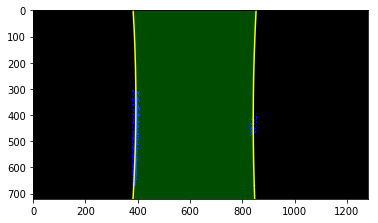

In [18]:
def line_search_in_margin(binary_warped_ms,left_fit_array,right_fit_array,toPrint = False,toRet = False,imgRet=False):

    nonzero = binary_warped_ms.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #take mean of last 20 frames
    left_fit = np.mean(left_fit_array[-20:],axis=0)
    right_fit = np.mean(right_fit_array[-20:],axis=0)
    
    margin=100
    
    #find indices
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + \
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + \
                    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + \
                     right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + \
                     right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a 2-degree polynomial function
    if( len(leftx) == 0 or len(lefty) == 0 or len(rightx) == 0 or len(righty) == 0 ):
        print('PL No pixel found')
        return None 
 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_array.append(left_fit)
    right_fit_array.append(right_fit)
    
    #Calculate mean again
    left_fit = np.mean(left_fit_array[-20:],axis=0)
    right_fit = np.mean(right_fit_array[-20:],axis=0)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_ms.shape[0]-1, binary_warped_ms.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    # Create an image for plotting
    out_img = np.dstack((binary_warped_ms, binary_warped_ms, binary_warped_ms))*255
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [0, 0, 255]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    dmargin = 350
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+dmargin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-dmargin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    #Lane drawing
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result_ml = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if toPrint == True:
        plt.imshow(result_ml)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    if toRet == True:
        return left_fit,right_fit,result_ml
    elif imgRet == True:
        return result_ml
    
left_fit,right_fit,result_ml = line_search_in_margin(binary_warped,left_fit_array,right_fit_array,toPrint = True,toRet = True,imgRet = False)

**Step 9. Radius of curvature and center offset**

In [19]:
def radius_of_curv_and_offset(binary_warped,left_fit_array,right_fit_array):
    
    left_fit = np.mean(left_fit_array[-10:],axis=0)
    right_fit = np.mean(right_fit_array[-10:],axis=0)
    
    #Generate x and y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Coversion from pixels to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    num_rows = binary_warped.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)
    #Fit new polynomial to y
    fit_cr_y = np.polyfit(y_points*ym_per_pix, left_fitx*xm_per_pix, 2)
    curverad_y = ((1 + (2*fit_cr_y[0]*y_eval*ym_per_pix + fit_cr_y[1])**2)**1.5) / np.absolute(2*fit_cr_y[0])
    
    #Fit new polynomial to x
    fit_cr_x = np.polyfit(y_points*ym_per_pix, right_fitx*xm_per_pix, 2)
    curverad_x = ((1 + (2*fit_cr_x[0]*y_eval*ym_per_pix + fit_cr_x[1])**2)**1.5) / np.absolute(2*fit_cr_x[0])
    average_radius = (curverad_y + curverad_x)/2
    
    lane_center = (left_fitx[719] + right_fitx[719])/2
    offset_pixels = abs(binary_warped.shape[1]/2 - lane_center)
    offset_in_mtrs = xm_per_pix*offset_pixels
    
    return average_radius,offset_in_mtrs

roc,oim = radius_of_curv_and_offset(binary_warped,left_fit_array,right_fit_array)
print("Radius of curvature %.2f m"%roc)
print("Center offset %.2f m"%oim)

Radius of curvature 2306.99 m
Center offset 0.13 m


**Step 10. Inverse warping and merging**

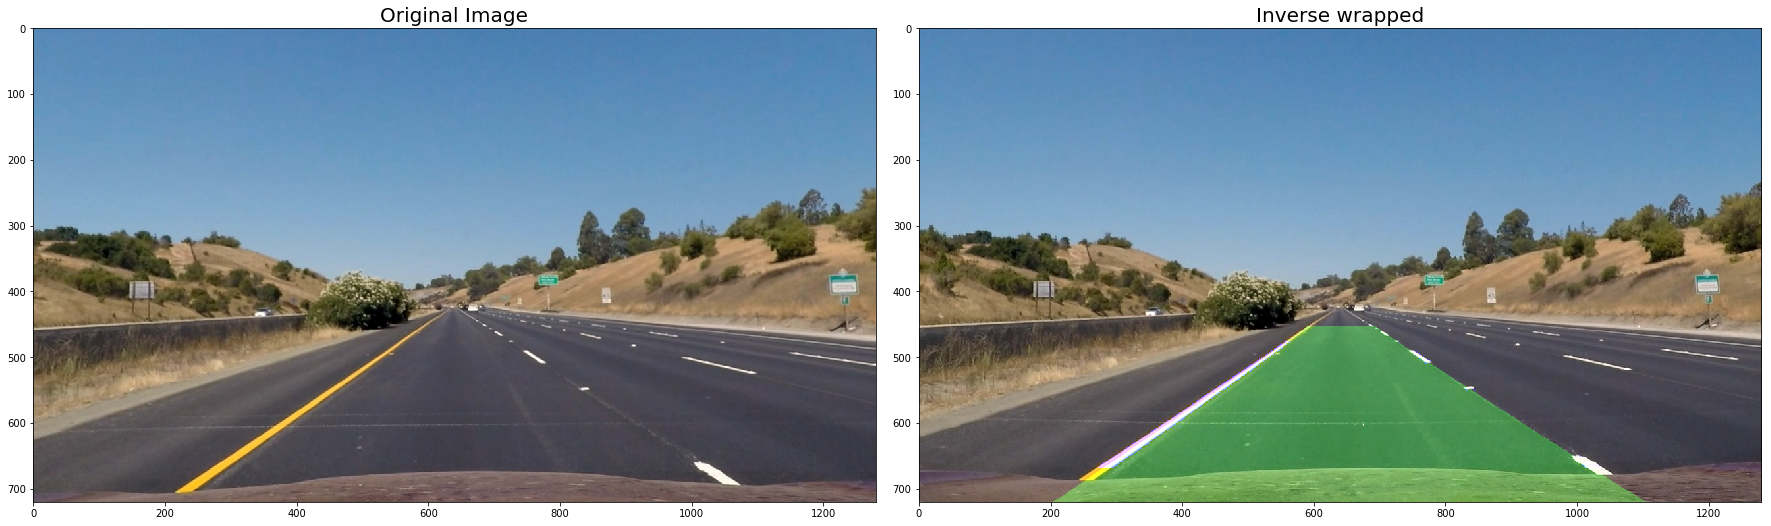

In [20]:
inverse_warped_img = perspective_transform(result_ml,M_inv)

# Merge original and processed image
final = cv2.addWeighted(org_image, 1, inverse_warped_img, 1, 0)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(final,cmap='gray')
ax2.set_title('Inverse wrapped', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


**Step 11. Final pipeline**

In [21]:
#Global variables 
left_fit_arrayp = [] #list of list of coefficients of y lane
right_fit_arrayp = [] #list of list of coefficients of x lane
radius_of_curvature = None

def pipeline(img):
    
    global left_fit_arrayp
    global right_fit_arrayp
    global radius_of_curvature
    
    binary_warped = image_processing(img)
    binary_w_3d = np.dstack((binary_warped,binary_warped,binary_warped))*255
    #Sliding window for first 20 frames then searching based on old lanes.
    if(len(left_fit_arrayp) < 20 or len(right_fit_arrayp) < 20):
        binary_warped_ll = sliding_window(binary_warped,left_fit_arrayp,right_fit_arrayp,toPrint = False,toRet = False,imgRet = True)
    else:
        binary_warped_ll = line_search_in_margin(binary_warped,left_fit_arrayp,right_fit_arrayp,toPrint = False,toRet = False,imgRet = True)
    
    if(binary_warped_ll is None):
        return binary_warped
    
    radius_of_curvature,center_offset = radius_of_curv_and_offset(binary_warped_ll,left_fit_arrayp,right_fit_arrayp)
    
    roc_string = "Radius of curvature is %.4f meter " % radius_of_curvature
    center_offset_string = "Center offset is %.4f meter "% center_offset
    binary_warped_inv = perspective_transform(binary_warped_ll,M_inv)
    
    binary_warped_wg = cv2.addWeighted(img, 0.5, binary_warped_inv, 0.5, 0)
    
    cv2.putText(binary_warped_wg,roc_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(binary_warped_wg, center_offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return binary_warped_wg


**Step 12. Passing video frame by frame to the pipeline**

In [22]:
from moviepy.editor import VideoFileClip
output = 'project_video_outputx1.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_outputx1.mp4
[MoviePy] Writing video project_video_outputx1.mp4


100%|█████████▉| 1260/1261 [05:11<00:00,  4.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_outputx1.mp4 

CPU times: user 7min 14s, sys: 16.2 s, total: 7min 30s
Wall time: 5min 13s
